Hunter Bennett  
Glass Lab  
Created 171208 | Last updated 171211  
____________  
This notebook explores our rna sequencing data for the three strains of mice. both at teh whole liver level and Kupffer cell specific level.

Compared to prior versions this one implements more quality control.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
# %load_ext rpy2.ipython

In [2]:
# define path to data
datapath = {'liver':'/data/mm10/Liver/RNA/', 'kupffer':'/data/mm10/Kupffer/RNA/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/171208_RNA_Seq/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'liver':['aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3A_JSS_TDT_16_09_28.balbcj.star_shifted_from_BALBCJ.sam', # balb3a had 'massive splenomegaly'
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3B_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3C_TDT_JSS_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3D_TDT_JSS_16_09_28.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1A_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1B_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1C_JSS_TDT_16_09_28.balbcj.star_shifted_from_BALBCJ.sam',
'NCoRWT_WholeLiver_RNA_polyA_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19',
'NCoRWT_WholeLiver_RNA-polyA-AMLNDiet-30week-LN141A-JSS-TDT-16-09-21',
'NCoRWT_WholeLiver_RNA-polyA-ControlDiet-30week-LN134B-JSS-TDT-16-09-21',
'NCoRWT_WholeLiver_RNA-polyA-ControlDiet-30week-LN134C-JSS-TDT-16-09-19',
'NCoRWT_WholeLiver_RNA_polyA_ControlDiet_30week_LN134D_JSS_TDT_16_09_21'],
'kupffer':["aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A_JSSTDT_16_09_26",
"aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3B_JSSTDT_16_09_26",
"aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3c_JSS_TDT_16_09_28",
"aj_KupfferTotal_RNA_polyA_ControlDiet_30week_AJ1c_JSS_TDT_16_09_28",
"aj_KupfferTotal_RNA_polyA_ControlDiet_30week_AJ1d_JSS_TDT_16_09_28",
"balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3a_JSS_TDT_16_09_28",
"balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3B_JSSTDT_16_09_26",
"balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3C_JSSTDT_16_09_26",
"balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3d_JSS_TDT_16_09_28", # balb3a had 'massive splenomegaly'
"balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1c_JSS_TDT_16_09_28",
"balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1d_JSS_TDT_16_09_28",
"NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [3]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '-' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '-' + samplesDF.diet + '-' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)

In [4]:
# set colors for the samples
color_dict = {'aj-control':'#fb9a99', 'aj-amln':'#e31a1c',
              'balbc-control':'#a6cee3', 'balbc-amln':'#1f78b4',
              'ncorwt-control':'#b2df8a', 'ncorwt-amln':'#33a02c'}
color_dict_tissue = {'aj-control-kupffer':'#fb9a99', 'aj-amln-kupffer':'#e31a1c',
            'balbc-control-kupffer':'#a6cee3', 'balbc-amln-kupffer':'#1f78b4',
            'ncorwt-control-kupffer':'#b2df8a', 'ncorwt-amln-kupffer':'#33a02c',
            'aj-control-liver':'#fdae6b', 'aj-amln-liver':'#e6550d',
            'balbc-control-liver':'#bcbddc', 'balbc-amln-liver':'#756bb1',
            'ncorwt-control-liver':'#bdbdbd', 'ncorwt-amln-liver':'#737373'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

Set some user defined functions

In [188]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z])[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)
        
def makeHub(samplelist, name, genome, plotoption=None, force=True):
    '''Takes a list of samples and runs the homer makeMultiWigHub.pl command with them
    '''
    mwcall = ['makeMultiWigHub.pl', name, genome]
    if plotoption != None:
        mwcall.extend(['-'+plotoption])
    mwcall.extend(['-url', 'http://homer.ucsd.edu/hubs/',
            '-webdir', '/homer_data/www/html/hubs'])
    if force:
        mwcall.extend(['-force'])
    mwcall.extend(['-d'])
    mwcall.extend(list(samplelist))
    subprocess.call(mwcall)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def process_rpkm(rpkm, conv_tpm = False):
    rpkm = rpkm.loc[rpkm.Length >= 200, :]

    # Create column for gene
    rpkm.loc[:, 'Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

    # clean up the columns a bit
    pattern = r"\s+\(.+\)$"
    rpkm.columns = pd.Series(rpkm.columns)\
            .str.replace(pattern, '')\
            .str.split('/')\
            .str[-1]
        
    #subset matrix of only counts
    rpkm_mat = rpkm.set_index('RepeatID').loc[:, rpkm.columns[
            rpkm.columns.to_series().str.contains('RNA')]]

    # create tpm matrix
    if conv_tpm:
        tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())
        return tpm_mat
    else:
        return rpkm_mat

In [189]:
makeHub(samplesDF.loc[samplesDF.sample_type=='kupffer', 'path'], 'hrb_kupffer_rna', 'mm10')

#### Anotate the RNA Seq Samples using python wrapper for annotateRepeats from the Homer package

In [6]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [# ('genes', False, None),
            # ('genes', True, None),
            # ('genes', 'False', 'rlog'), # ignore the rlog transform values for now
            # ('genes', False, 'rpkm'),
            ('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [7]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rlog -d /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam /data/mm10/Liver/RNA/balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3A_JSS_TDT_16_09_28.balbcj.star_shifted_from_BALBCJ.sam /data/mm10/Liver/RNA/balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3B_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam /data/mm10/Li

###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

In [1]:
rpkm.head()

NameError: name 'rpkm' is not defined

In [2]:
rpkm = pd.read_csv(outdir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm.Length + 1))

NameError: name 'pd' is not defined

In [ ]:
rpkm.head()

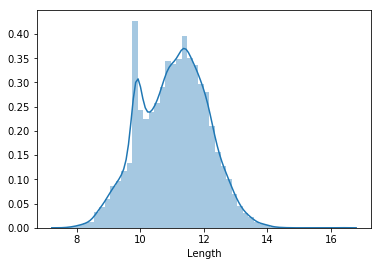

In [9]:
# Filter small mRNAs (transcripts with length < 200 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 200, :]
sns.distplot(np.log2(rpkm.Length + 1))

In [10]:
tpm_mat = process_rpkm(rpkm, conv_tpm=True)

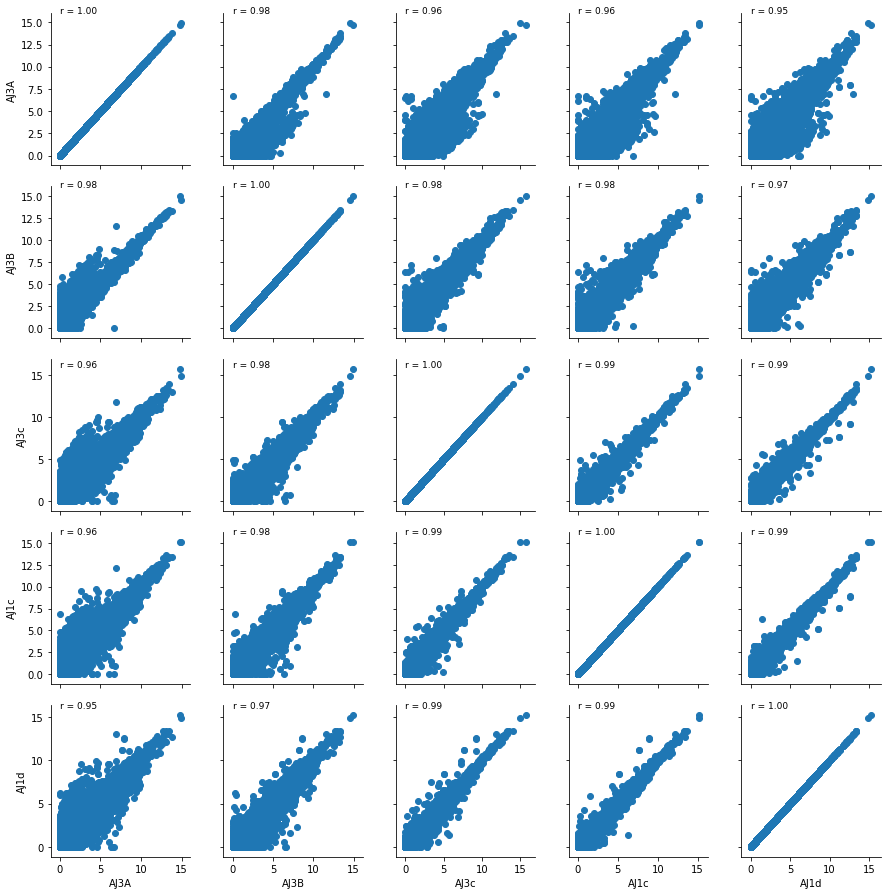

In [11]:
tpm_paired_scatter(tpm_mat, 'aj', tissue='Kupffer')

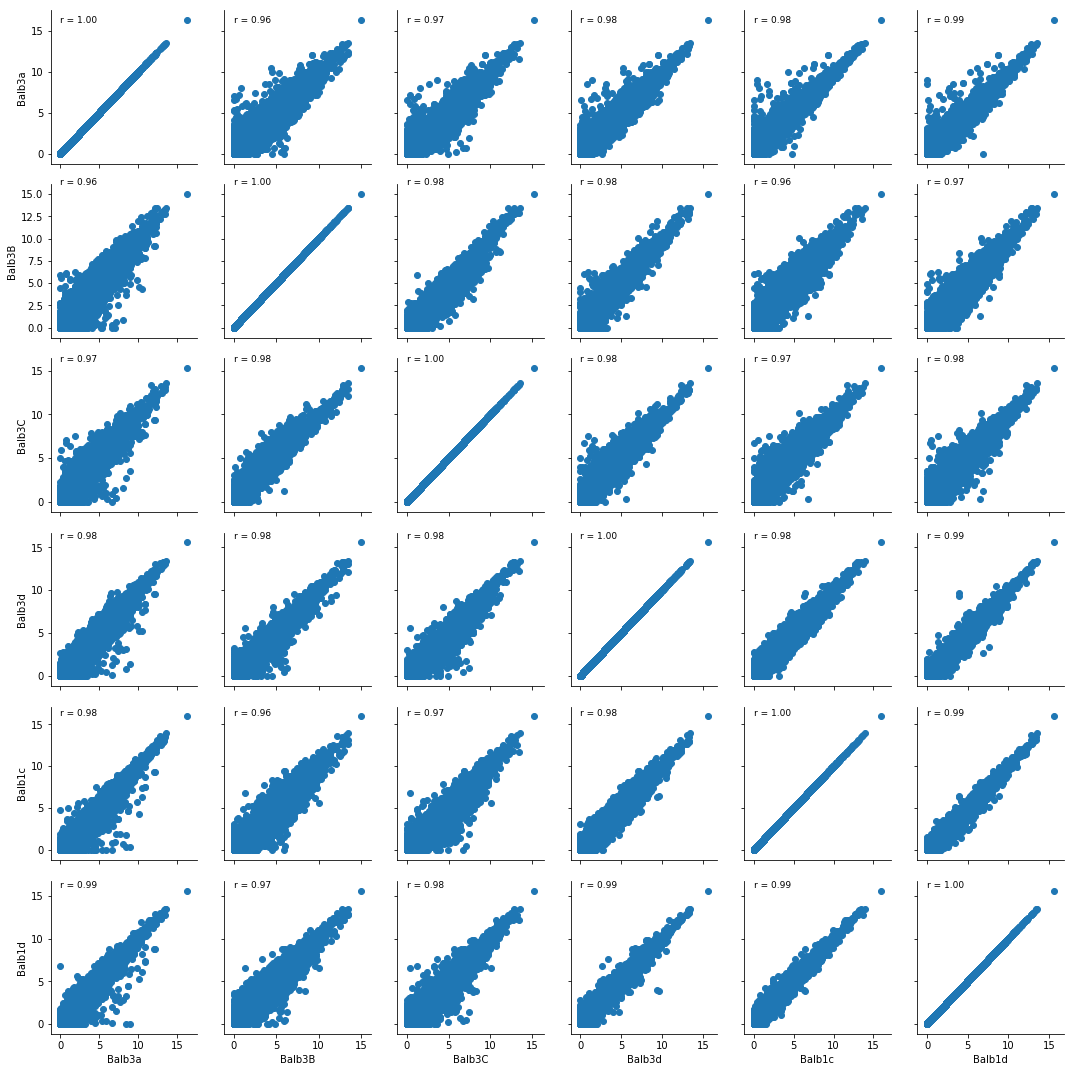

In [12]:
tpm_paired_scatter(tpm_mat, 'balb', tissue='Kupffer')

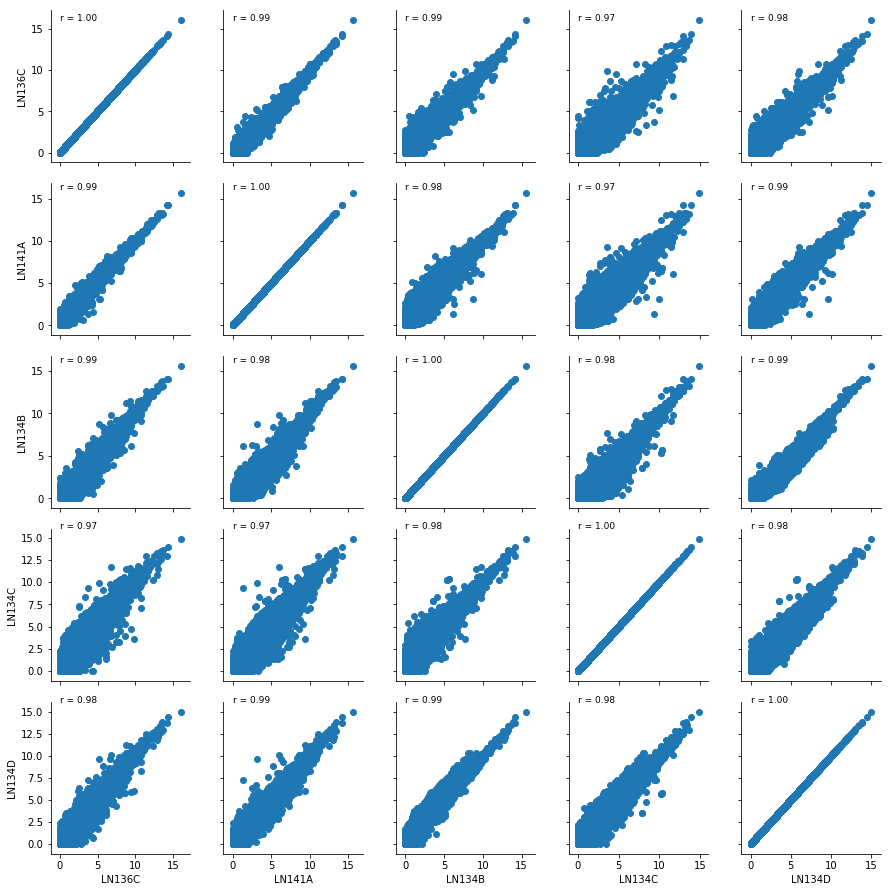

In [13]:
tpm_paired_scatter(tpm_mat, 'ncor', tissue='kupffer')

### PCA Analysis of the Data

In [14]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group_tissue, samplesDF.subject])).reset_index()
tpm_pca_df['mouse'] = tpm_pca_df.subject.str.split('_').str[6]

#### PC1 appears to be picking up most of the tissue driven variation between the samples
at least at first glance there doesn't really seem to be clear delineation between the conditions or strains

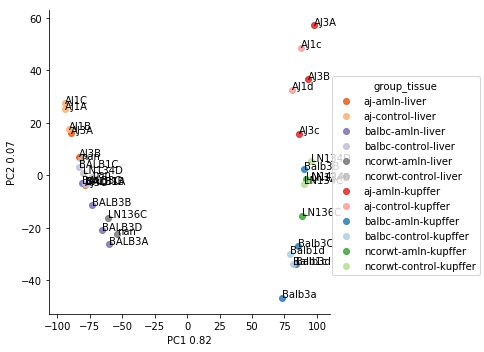

In [15]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))

label_point(tpm_pca_df.PC1, tpm_pca_df.PC2,
            tpm_pca_df.mouse, plt.gca())

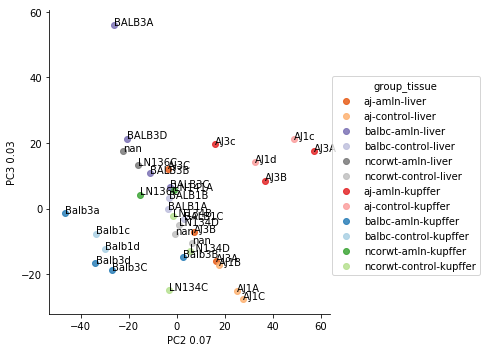

In [16]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC2 %.2f' % exp_var[1]), ylabel=('PC3 %.2f' % exp_var[2]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.mouse, plt.gca())

### Consider implementing a 3D plot below
____
**TBD**

## Tissue specific PCA

In [17]:
def df_col_subset(x, id_str):
    import pandas as pd
    import re
    '''Returns pandas dataframe with only columns containing id_str'''
    return x[x.columns[pd.Series(x.columns).str.contains(id_str, flags=re.IGNORECASE)]]

### Whole Liver

In [18]:
# standardize matrix, mean=0, std=1
l_tpm = hbUtils.df_col_subset(tpm_mat, 'Liver')
l_tpm_std = StandardScaler().fit_transform(l_tpm) # scale data
# run PCA
l_pca = PCA(n_components=3)
l_tpm_pca = l_pca.fit_transform(l_tpm_std.T)
exp_var = l_pca.explained_variance_ratio_
#create df for plotting
l_tpm_pca_df = pd.DataFrame(l_tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF[samplesDF.sample_type=='liver'].group_tissue,
                        samplesDF[samplesDF.sample_type=='liver'].subject])).reset_index()
l_tpm_pca_df['mouse'] = l_tpm_pca_df.subject.str.split('_|-').str[6]

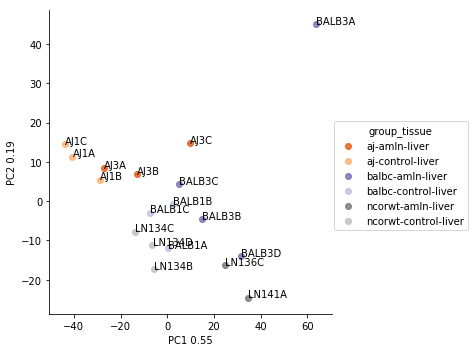

In [19]:
ax = sns.lmplot('PC1', 'PC2', l_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(l_tpm_pca_df.PC1, l_tpm_pca_df.PC2, l_tpm_pca_df.mouse, plt.gca())

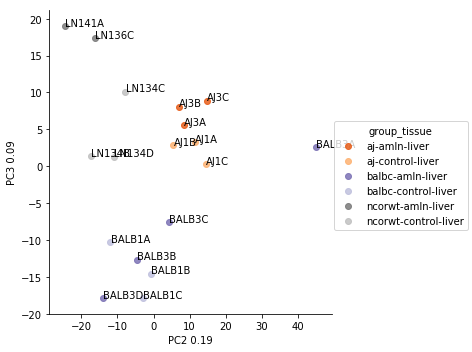

In [20]:
ax = sns.lmplot('PC2', 'PC3', l_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC2 %.2f' % exp_var[1]), ylabel=('PC3 %.2f' % exp_var[2]))
label_point(l_tpm_pca_df.PC2, l_tpm_pca_df.PC3, l_tpm_pca_df.mouse, plt.gca())

#### From these studies BALB3A appears to be an outlier in the whole liver sample
_____
The mouse was noted to have splenomegaly upon liver isolation and processing. Since we have three balbc amln samples we should probably just exclude this sample from further downstream analysis (for both Kupffer and Liver)

follow up on BALB3A

#### PC analysis with only the balb samples 

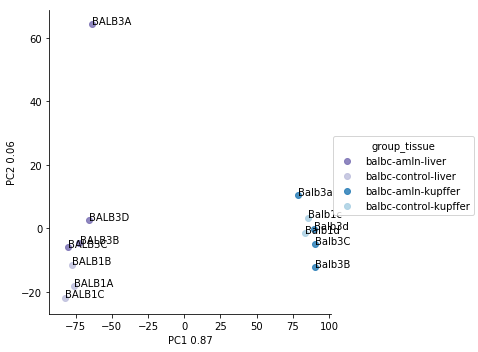

In [21]:
# standardize matrix, mean=0, std=1
b_tpm = hbUtils.df_col_subset(tpm_mat, 'balb')
b_tpm_std = StandardScaler().fit_transform(b_tpm) # scale data
# run PCA
l_pca = PCA(n_components=3)
b_tpm_pca = l_pca.fit_transform(b_tpm_std.T)
exp_var = l_pca.explained_variance_ratio_
#create df for plotting
b_tpm_pca_df = pd.DataFrame(b_tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF[samplesDF.strain=='balbc'].group_tissue,
                        samplesDF[samplesDF.strain=='balbc'].subject])).reset_index()
b_tpm_pca_df['mouse'] = b_tpm_pca_df.subject.str.split('_|-').str[6]
ax = sns.lmplot('PC1', 'PC2', b_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(b_tpm_pca_df.PC1, b_tpm_pca_df.PC2, b_tpm_pca_df.mouse, plt.gca())

####  PC analysis with balb kupffer

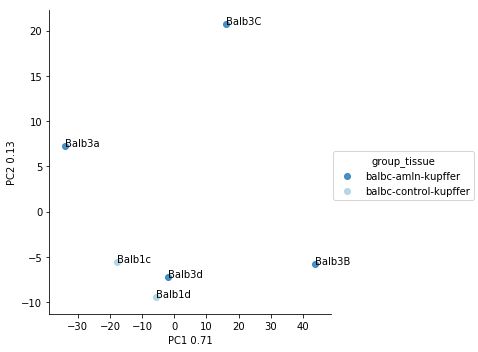

In [22]:
# standardize matrix, mean=0, std=1
bk_tpm = hbUtils.df_col_subset(tpm_mat, 'balb.*kupffer')
bk_tpm_std = StandardScaler().fit_transform(bk_tpm) # scale data
# run PCA
l_pca = PCA(n_components=3)
bk_tpm_pca = l_pca.fit_transform(bk_tpm_std.T)
exp_var = l_pca.explained_variance_ratio_
#create df for plotting
bk_tpm_pca_df = pd.DataFrame(bk_tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF[(samplesDF.strain=='balbc') & (samplesDF.sample_type=='kupffer')].group_tissue,
                        samplesDF[(samplesDF.strain=='balbc') & (samplesDF.sample_type=='kupffer')].subject])).reset_index()
bk_tpm_pca_df['mouse'] = bk_tpm_pca_df.subject.str.split('_|-').str[6]

ax = sns.lmplot('PC1', 'PC2', bk_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(bk_tpm_pca_df.PC1, bk_tpm_pca_df.PC2, bk_tpm_pca_df.mouse, plt.gca())

#### PC analysis with balb liver

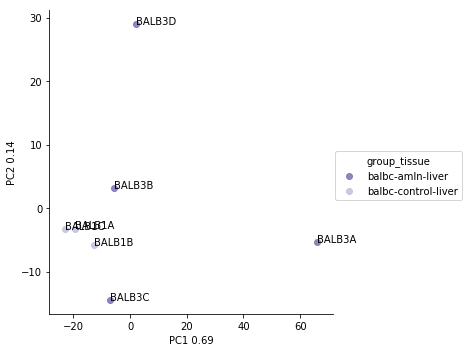

In [43]:
# standardize matrix, mean=0, std=1
bl_tpm = hbUtils.df_col_subset(tpm_mat, 'balb.*liver')
bl_tpm_std = StandardScaler().fit_transform(bl_tpm) # scale data
# run PCA
bl_pca = PCA(n_components=3)
bl_tpm_pca = bl_pca.fit_transform(bl_tpm_std.T)
exp_var = bl_pca.explained_variance_ratio_
#create df for plotting
bl_tpm_pca_df = pd.DataFrame(bl_tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF[(samplesDF.strain=='balbc') & (samplesDF.sample_type=='liver')].group_tissue,
                        samplesDF[(samplesDF.strain=='balbc') & (samplesDF.sample_type=='liver')].subject])).reset_index()
bl_tpm_pca_df['mouse'] = bl_tpm_pca_df.subject.str.split('_|-').str[6]

ax = sns.lmplot('PC1', 'PC2', bl_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(bl_tpm_pca_df.PC1, bl_tpm_pca_df.PC2, bl_tpm_pca_df.mouse, plt.gca())

### The principal components for each gene should help us figure out which genes are driving this segregation of BALB3A from the rest of the samples 

In [72]:
# annotate the pcs with refseq gene IDs
transcript_pc = pd.DataFrame(bl_pca.components_.T, tpm_mat.index, columns=['PC1','PC2','PC3'])

In [73]:
# look at the genes with the highest loading in PC1
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
RepeatID,,,
NM_017370,0.514131,-0.169339,0.094907
NM_133977,0.394099,0.006719,-0.118576
NM_017371,0.318460,-0.096039,-0.061398
NM_181849,0.202770,-0.191912,-0.064822
NM_013602,0.163760,-0.053467,-0.060488
NM_009117,0.110188,-0.049666,0.008160
NM_001276450,0.094060,0.146583,0.115837
NM_011314,0.090577,-0.039555,0.010500
NM_133862,0.068690,-0.063003,-0.066018


In [74]:
pc1_mrna = list(transcript_pc.loc[transcript_pc.PC1 >= 0.05, :].index)

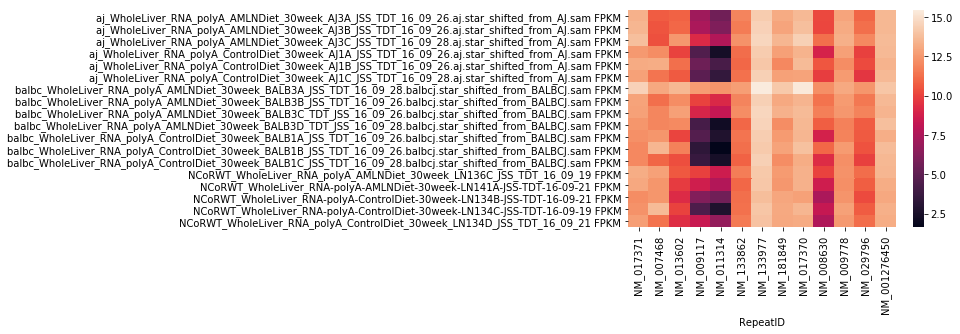

In [101]:
sns.heatmap(np.log2(l_tpm[l_tpm.index.str.contains('|'.join(pc1_mrna))].T + 1))

Some of the gene that are discriminating 3A from the other samples in the liver include serum amyloid a (1 and 2) as well as haptoglobin and hemopexin. Saa is an acute phase reactant and haptoglobin and hemopexin are also induced in infection to scavenge iron. These would suggest that 3A had an infection or tumor or some other inflammatory stimulus.

However the transferrin levels are also high in 3A. Tfr should actually be low in settings of induced inflammation.

In [159]:
# lets look at the raw counts in each of these samples too...
# import the raw count file
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

In [167]:
(counts_df.iloc[:, 8:]).sum()

/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam (32122589.0 total)                    27810927.0
/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam (27661918.0 total)                    24071977.0
/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam (22149682.0 total)                    19204159.0
/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam (27815677.0 total)                 24324747.0
/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam (26595552.0 total)                 22939281.0
/data/mm10/Liver/RNA/aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam (23861269.0 total)                 20798427.0
/data/mm10/Liver/RNA/balbc_WholeLiver_RN

the actual counts don't really seem that different either'

### Kupffer Cells

In [24]:
# standardize matrix, mean=0, std=1
k_tpm = hbUtils.df_col_subset(tpm_mat, 'Kupffer')
k_tpm_std = StandardScaler().fit_transform(k_tpm) # scale data
# run PCA
k_pca = PCA(n_components=3)
k_tpm_pca = k_pca.fit_transform(k_tpm_std.T)
exp_var = l_pca.explained_variance_ratio_
#create df for plotting
k_tpm_pca_df = pd.DataFrame(k_tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF[samplesDF.sample_type=='kupffer'].group_tissue,
                        samplesDF[samplesDF.sample_type=='kupffer'].subject])).reset_index()
k_tpm_pca_df['mouse'] = k_tpm_pca_df.subject.str.split('_|-').str[6]

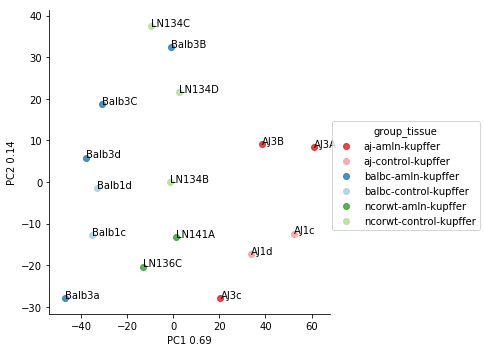

In [25]:
ax = sns.lmplot('PC1', 'PC2', k_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(k_tpm_pca_df.PC1, k_tpm_pca_df.PC2, k_tpm_pca_df.mouse, plt.gca())

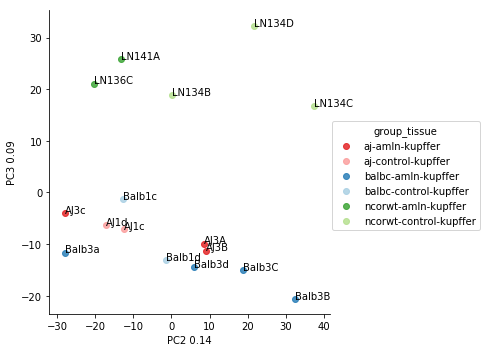

In [26]:
ax = sns.lmplot('PC2', 'PC3', k_tpm_pca_df, fit_reg=False,
           hue='group_tissue', palette=color_dict_tissue)
ax.set(xlabel=('PC2 %.2f' % exp_var[1]), ylabel=('PC3 %.2f' % exp_var[2]))
label_point(k_tpm_pca_df.PC2, k_tpm_pca_df.PC3, k_tpm_pca_df.mouse, plt.gca())

### Heirachal clustering of samples

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


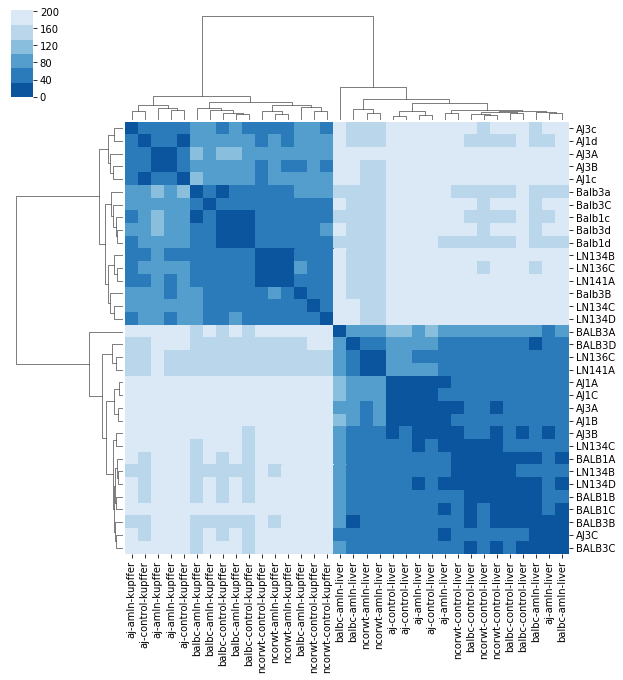

In [27]:
samplesDF['mouse'] = samplesDF.subject.str.split('_|-').str[6]
# calculate euclidean distance between samples
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.group_tissue),
                        index = list(samplesDF.mouse))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

In [28]:
#write tpm matrices for WGCNA analysis
l_tpm.to_csv(outdir + 'liver_tpm_counts.txt', sep='\t')
k_tpm.to_csv(outdir + 'kupffer_tpm_counts.txt', sep='\t')

## Differential Analysis (DESeq2)

Prep data for importing into R

In [29]:
# import the raw count file
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

# drop samples that need to be excluded
to_drop = pd.Series(counts_df.columns).str.contains(
        '|'.join(samplesDF.subject[samplesDF.exclusion == True]))
to_drop[0] = False
counts_df = counts_df.loc[:, list(~to_drop)]
counts_df.head()

# create gene name column
counts_df['Gene'] = pd.Series([x.split('|')[0] for x in counts_df['Annotation/Divergence']])

# clean up columns
counts_df.columns = pd.Series(counts_df.columns)\
        .str.split(r" \(").str[0]\
        .str.split('/.*/').str[-1]
counts_df = counts_df.set_index('Transcript/RepeatID')

# subset just the samples
counts_mat_l = hbUtils.df_col_subset(hbUtils.df_col_subset(counts_df, 'liver'), 'aj|balb|ncor')
counts_mat_k = hbUtils.df_col_subset(hbUtils.df_col_subset(counts_df, 'kupffer'), 'aj|balb|ncor')

#### Write the data for DESeq2

Liver

In [30]:
# Liver
# raw count matrix for DESeq
liver_raw_counts_file = raw_counts_file.replace('.txt', '_liver_mat_deseq.txt')                                    
if not os.path.isfile(outdir + liver_raw_counts_file):
    counts_mat_l.to_csv(outdir + liver_raw_counts_file, sep='\t')
    
# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data_l = samplesDF.loc[(samplesDF.sample_type=='liver') & ~samplesDF.exclusion,
                           ['subject', 'strain', 'diet', 'sample_type']]
col_data_l = col_data_l.set_index('subject')
liver_col_file = raw_counts_file.replace('.txt', 'liver_col_info.txt')
if not os.path.isfile(outdir + liver_col_file):
    col_data_l.to_csv(outdir + liver_col_file, sep='\t')

Kupffer cells

In [31]:
# raw count matrix for DESeq
kupffer_raw_counts_file = raw_counts_file.replace('.txt', '_kupffer_mat_deseq.txt')                                   
if not os.path.isfile(outdir + kupffer_raw_counts_file):
    counts_mat_l.to_csv(outdir + kupffer_raw_counts_file, sep='\t')

# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data_k = samplesDF.loc[(samplesDF.sample_type=='kupffer') & ~samplesDF.exclusion,
                           ['subject', 'strain', 'diet', 'sample_type']]
col_data_k = col_data_k.set_index('subject')
kupffer_col_file = raw_counts_file.replace('.txt', 'kupffer_col_info.txt')
if not os.path.isfile(outdir + kupffer_col_file):
    col_data_k.to_csv(outdir + kupffer_col_file, sep='\t')

### Analyze Kupffer Cell Data

#### First lets try and figure out what model we should use. DESeq has the ability to model interaction terms between the strain and diet, however this would make for a fairly complicated downstream analysis.
____
To try and figure out how to analyze this data lets use the likelihood ratio test in DESeq to assess the differences in dispersions between the fitted count data (one version fitted with the full model, one with reduced). This should give us a gene by gene assessment of how well the model explains the data compared to a simpler null.

In [21]:
%%R -i counts_mat_k,col_data_k,outdir
# load DESeq
library("DESeq2")

col_data_k$diet <- relevel(col_data_k$diet, ref='control')
col_data_k$strain <- relevel(col_data_k$strain, ref='ncorwt')

#create DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts_mat_k,
                             colData = col_data_k,
                             design = ~ strain + diet + strain:diet)

# run DESeq LRT to assess effect of strains on diet
dds <- DESeq(dds, test="LRT", reduced= ~ strain + diet)
res <- results(dds, alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/lrt_strainsdiet_interaction_deseq_results.txt"))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rp

#### First lets try and figure out what model we should use. DESeq has the ability to model interaction terms between the strain and diet, however this would make for a fairly complicated downstream analysis.
____
To try and figure out how to analyze this data lets use the likelihood ratio test in DESeq to assess the differences in dispersions between the fitted count data (one version fitted with the full model, one with reduced). This should give us a gene by gene assessment of how well the model explains the data compared to a simpler null.

### assess effect of interaction term

In [28]:
intx = pd.read_csv(outdir + "/lrt_strainsdiet_interaction_deseq_results.txt")

In [29]:
(intx.padj <= 0.01).value_counts()

False    24439
True        98
Name: padj, dtype: int64

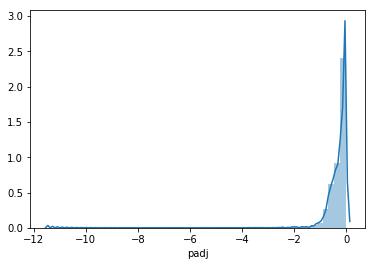

In [30]:
sns.distplot(np.log10(intx.padj.dropna()))

** We see above that 98 genes pass the padj (BH FDR) < 0.1 cutoff as being better fit by the interaction term model. This merits further follow up... **


#### Run DESeq2 with interaction model
____
This is following the DESeq manual for how to model interactions. See online documentation or enter '?results' in R with DESeq2 package loaded.

In [25]:
%%R -i counts_mat_k,col_data_k,outdir
# load DESeq
library("DESeq2")

col_data_k$diet <- relevel(col_data_k$diet, ref='control')
col_data_k$strain <- relevel(col_data_k$strain, ref='ncorwt')

#create DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts_mat_k,
                             colData = col_data_k,
                             design = ~ strain + diet + strain:diet)

# run DESeq with full model
dds <- DESeq(dds)

# diet effect for ncorwt
res <- results(dds, contrast=c('diet', 'amln', 'control'), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/ncorwt_amln_deseq_results.txt"))

# diet effect for balbc
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainbalbc.dietamln') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_amln_deseq_results.txt"))

# diet effect for aj
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainaj.dietamln') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/aj_amln_deseq_results.txt"))

# interaction term for condition effect between balbc and ncorwt
res <- results(dds, name='strainbalbc.dietamln', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_ncorwt_amln_interaction_deseq_results.txt"))

# interaction term for condition effect between aj and ncorwt
res <- results(dds, name='strainaj.dietamln', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/aj_ncorwt_amln_interaction_deseq_results.txt"))

# interaction term for condition effect between balbc and aj
res <- results(dds, contrast=list("strainbalbc.dietamln", "strainaj.dietamln"), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_aj_amln_interaction_deseq_results.txt"))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntim

### BALBC differentially regulated genes

In [32]:
def intersect(list1, list2):
    return list(set(list1) & set(list2))

In [33]:
balb_amln = pd.read_csv(outdir + "/balbc_amln_deseq_results.txt")
balb_aj = pd.read_csv(outdir + "/balbc_aj_amln_interaction_deseq_results.txt")
balb_ncor = pd.read_csv(outdir + "/balbc_ncorwt_amln_interaction_deseq_results.txt")

In [34]:
# combine into one DF
balb = balb_amln.merge(balb_aj.merge(balb_ncor, how='outer', on='Unnamed: 0',
                                    suffixes=('_balb_aj', '_balb_ncor')),
                      how='outer', on='Unnamed: 0')

Next, to start analyzing this data, we will ask how many of the differentially induced genes in balbc by the amln diet are also differentially induced in balb compared to aj

In [35]:
balb_aj_spec = ((np.abs(balb.log2FoldChange) >= 1) & (balb.padj <=0.05) & (balb.padj_balb_aj <= 0.05))
balb_aj_spec.value_counts()

False    24531
True         6
dtype: int64

In [36]:
balb_ncor_spec = ((np.abs(balb.log2FoldChange) >= 1) & (balb.padj <=0.05) & (balb.padj_balb_ncor <= 0.05))
balb_ncor_spec.value_counts()

False    24392
True       145
dtype: int64

In [37]:
((balb_aj_spec) & (balb_ncor_spec)).value_counts()

False    24532
True         5
dtype: int64

^ thus all 19 of the balb/aj specific genes are balb ncor specific genes

In [38]:
balb_spec_refseq = balb.loc[((balb_aj_spec) & (balb_ncor_spec)), 'Unnamed: 0']

Lets plot their expression...

In [39]:
# load in rpkm file without adjustments
rpkm_genes_raw = pd.read_csv(outdir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')

# drop the balb3A columns
to_drop = pd.Series(rpkm_genes_raw.columns).str.contains(
        '|'.join(samplesDF.subject[samplesDF.exclusion == True]))
to_drop[0] = False
rpkm_genes_raw = rpkm_genes_raw.loc[:, list(~to_drop)]

# generate tissue specific rpkm files for plotting
rpkm_genes_raw_k= hbUtils.df_col_subset(rpkm_genes_raw,
        'chr|start|end|strand|Length|Copies|Annotation|.*Kupffer.*')
rpkm_genes_raw_l= hbUtils.df_col_subset(rpkm_genes_raw,
        'chr|start|end|strand|Length|Copies|Annotation|.*Liver.*')

In [40]:
balb_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(balb_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

### Kupffer Cell Expression of Balbc specific genes

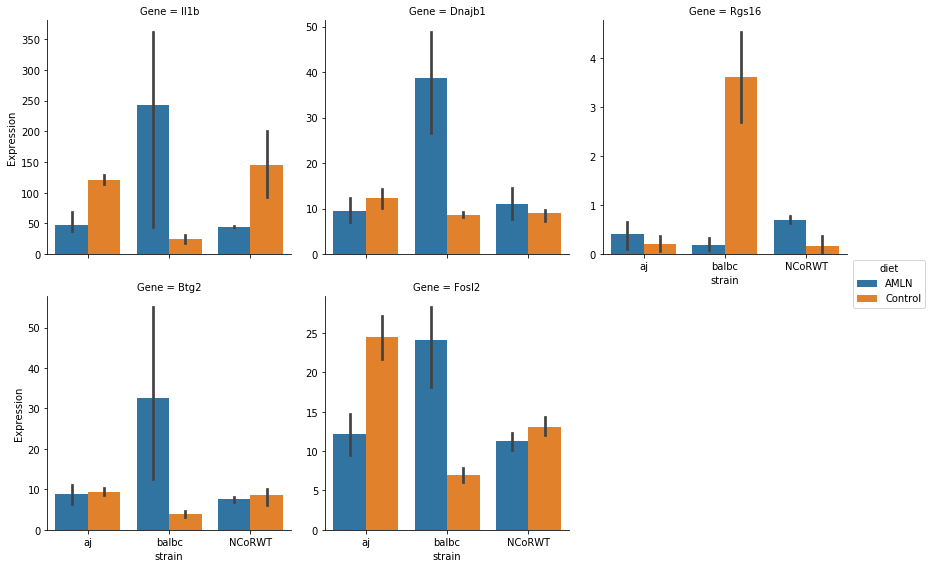

In [41]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + balb_spec_genes + '\|') + '|fosl2')

### Whole Liver Expression of Balbc specific genes

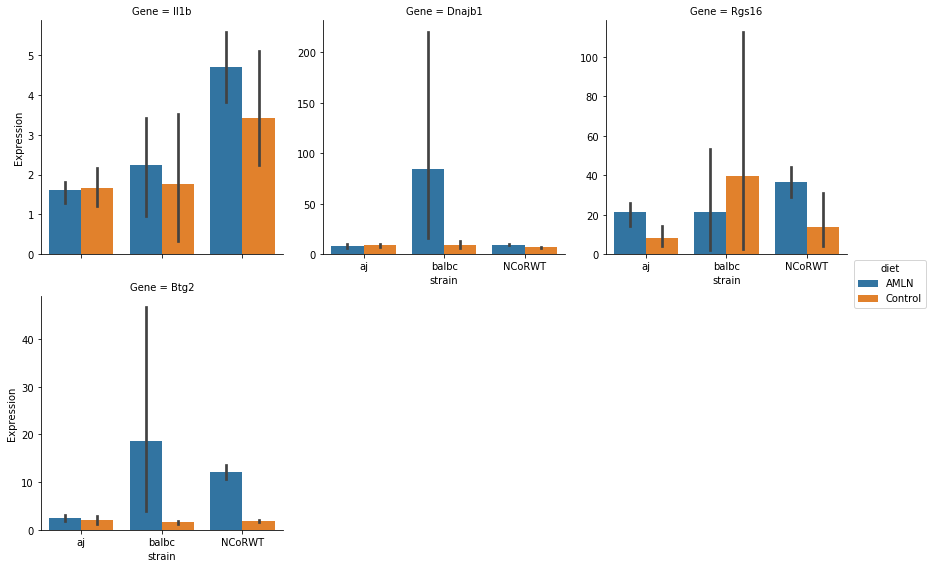

In [45]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + balb_spec_genes + '\|'))

Unclear how to exactly interpret the above gene expression differences. interesting that the inflammatory gene Il1b would be increased in balb given that they do not have the inflammatory phenotype that we see in the other mice livers.  
**Jason wants to see if these genes are conserved in the strain specific response to CCl4.**

### AJ differentially regulated genes

In [46]:
aj_amln = pd.read_csv(outdir + "/aj_amln_deseq_results.txt")
aj_balb = pd.read_csv(outdir + "/balbc_aj_amln_interaction_deseq_results.txt")
aj_ncor = pd.read_csv(outdir + "/aj_ncorwt_amln_interaction_deseq_results.txt")

In [47]:
# combine into one DF
aj = aj_amln.merge(aj_balb.merge(aj_ncor, how='outer', on='Unnamed: 0',
                                    suffixes=('_aj_balb', '_aj_ncor')),
                      how='outer', on='Unnamed: 0')

In [48]:
aj_balb_spec = ((np.abs(aj.log2FoldChange) >= 1) & (aj.padj <=0.05) & (aj.padj_aj_balb <= 0.05))
aj_balb_spec.value_counts()

False    24532
True         5
dtype: int64

In [49]:
aj_ncor_spec = ((np.abs(aj.log2FoldChange) >= 1) & (aj.padj <=0.05) & (aj.padj_aj_ncor <= 0.05))
aj_ncor_spec.value_counts()

False    24530
True         7
dtype: int64

In [51]:
((aj_balb_spec) & (aj_ncor_spec)).value_counts()


False    24536
True         1
dtype: int64

In [52]:
# aj specific refseq ids
aj_spec_refseq = aj.loc[((aj_balb_spec) & (aj_ncor_spec)), 'Unnamed: 0']

# Get aj spec gene names
aj_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(aj_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


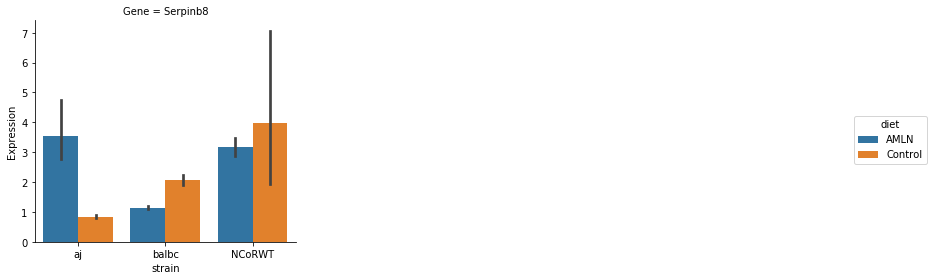

In [54]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + aj_spec_genes))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


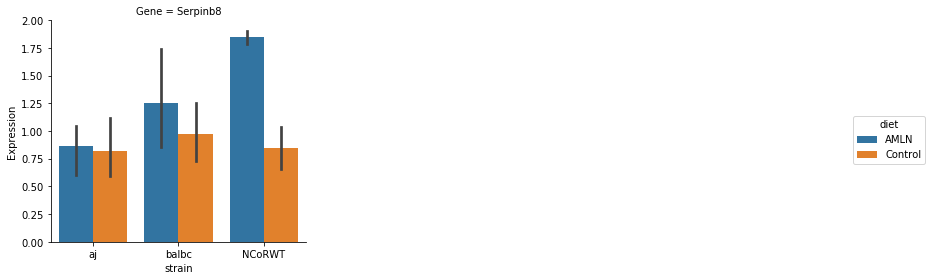

In [55]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + aj_spec_genes))

### NCoRWT (C57/BL6) differentially regulated genes

In [105]:
ncorwt_amln = pd.read_csv(outdir + "/ncorwt_amln_deseq_results.txt")
ncorwt_aj = pd.read_csv(outdir + "/aj_ncorwt_amln_interaction_deseq_results.txt")
ncorwt_balb = pd.read_csv(outdir + "/balbc_ncorwt_amln_interaction_deseq_results.txt")

In [106]:
# combine into one DF
ncorwt = ncorwt_amln.merge(ncorwt_balb.merge(ncorwt_aj, how='outer', on='Unnamed: 0',
                                             suffixes=('_ncorwt_balb', '_ncorwt_aj')),
                           how='outer', on='Unnamed: 0')

In [107]:
ncorwt_balb_spec = ((np.abs(ncorwt.log2FoldChange) >= 1) & (ncorwt.padj <=0.05) & (ncorwt.padj_ncorwt_balb <= 0.05))
ncorwt_balb_spec.value_counts()

False    24414
True       123
dtype: int64

In [108]:
ncorwt_aj_spec = ((np.abs(ncorwt.log2FoldChange) >= 1) & (ncorwt.padj <=0.05) & (ncorwt.padj_ncorwt_aj <= 0.05))
ncorwt_aj_spec.value_counts()

False    24486
True        51
dtype: int64

In [109]:
(ncorwt_aj_spec & ncorwt_balb_spec).value_counts()

False    24492
True        45
dtype: int64

In [110]:
# ncorwt specific refseq ids
ncorwt_spec_refseq = ncorwt.loc[((ncorwt_balb_spec) & (ncorwt_aj_spec)), 'Unnamed: 0']

# Get ncorwt spec gene names
ncorwt_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(ncorwt_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

#### Kupffer cell expression

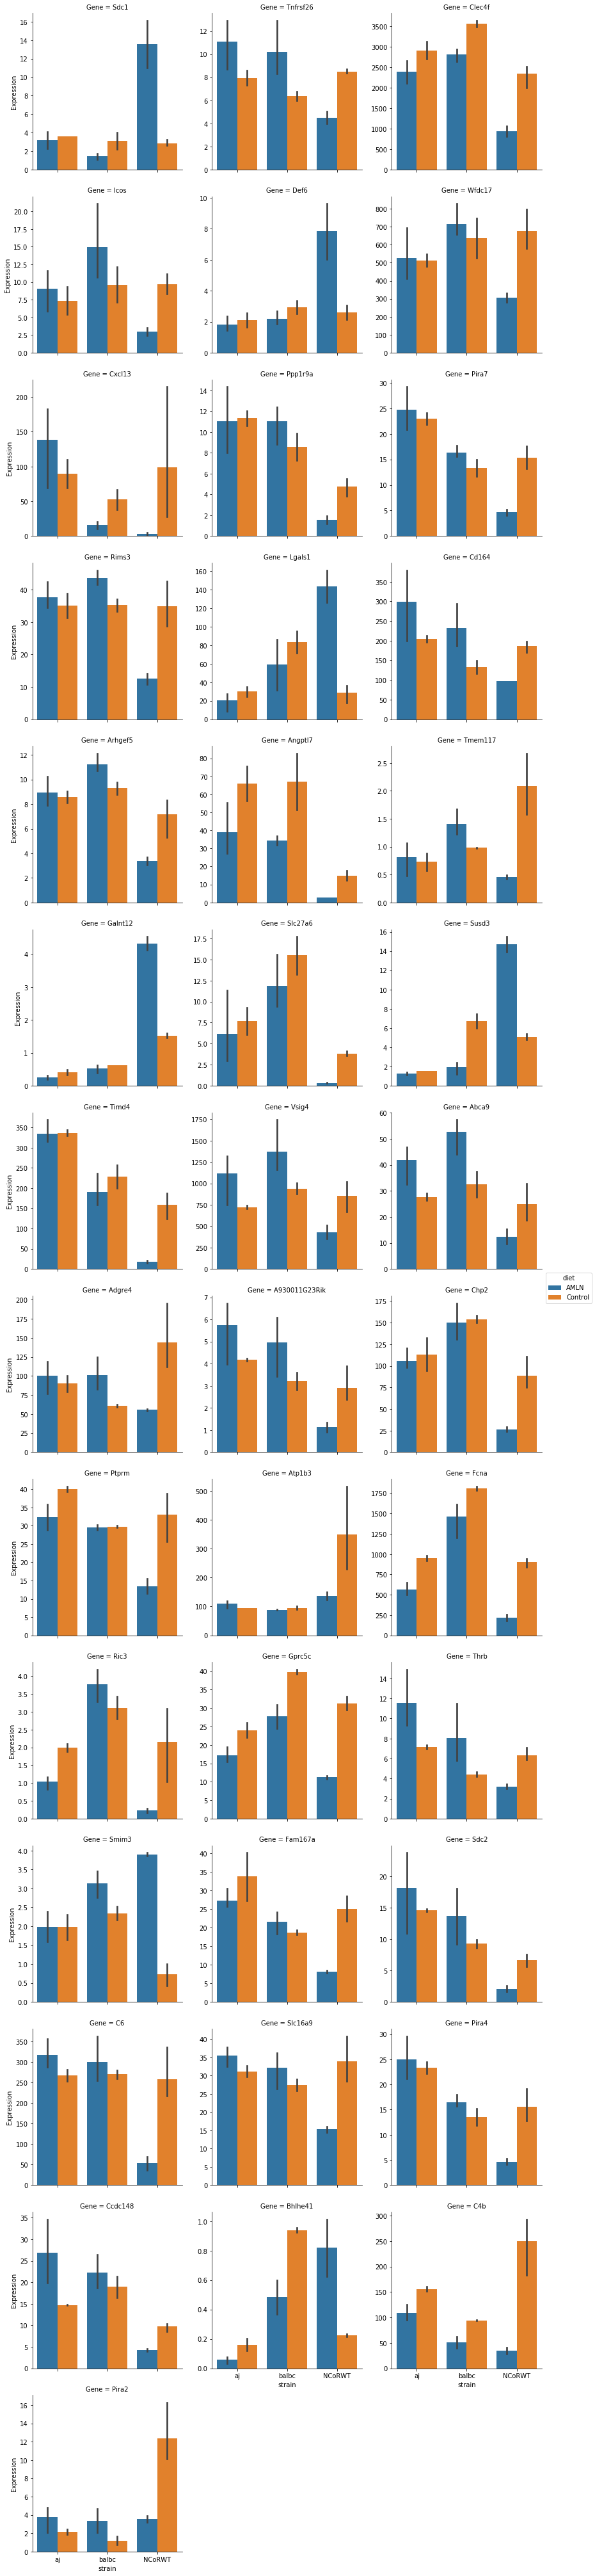

In [111]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + ncorwt_spec_genes + '\|'))

#### liver expression


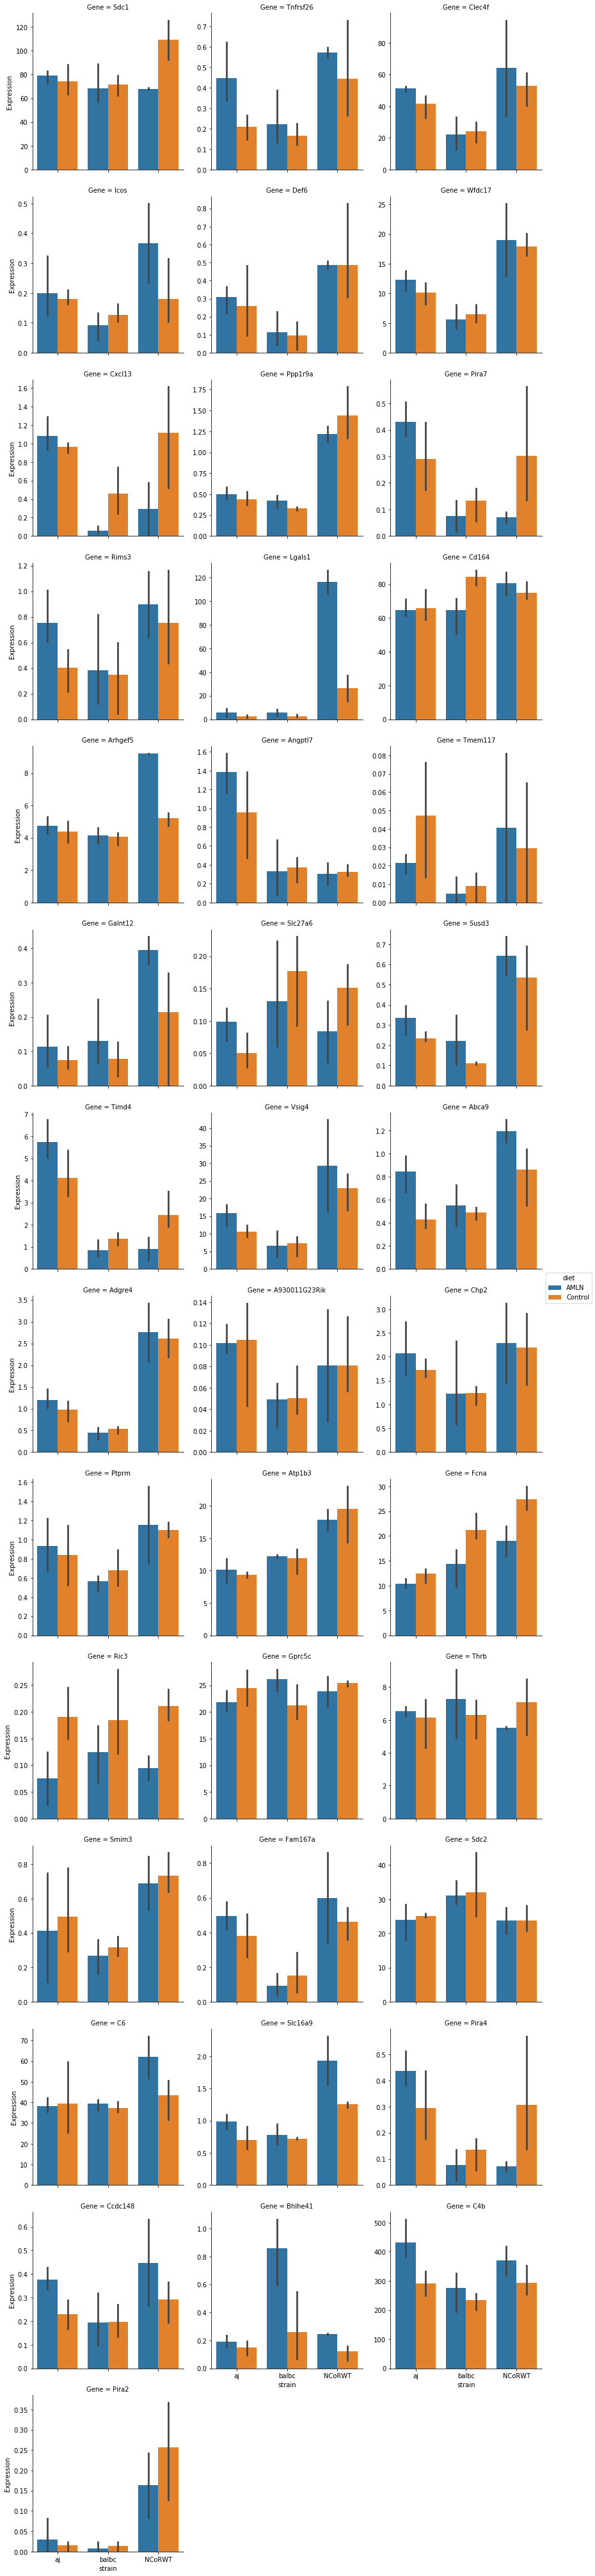

In [112]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + ncorwt_spec_genes + '\|'))

## Analyze Whole Liver RNA Seq Data 

In [68]:
%%R -i counts_mat_l,col_data_l,outdir
# load DESeq
library("DESeq2")

colnames(counts_mat_l) <- NULL

col_data_l$diet <- relevel(col_data_l$diet, ref='control')
col_data_l$strain <- relevel(col_data_l$strain, ref='ncorwt')

#create DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts_mat_l,
                             colData = col_data_l,
                             design = ~ strain + diet + strain:diet)

# run DESeq with full model
dds <- DESeq(dds)

# diet effect for ncorwt
res <- results(dds, contrast=c('diet', 'amln', 'control'), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/ncorwt_amln_wholeliver_deseq_results.txt"))

# diet effect for balbc
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainbalbc.dietamln') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_amln_wholeliver_deseq_results.txt"))

# diet effect for aj
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainaj.dietamln') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/aj_amln_wholeliver_deseq_results.txt"))

# interaction term for condition effect between balbc and ncorwt
res <- results(dds, name='strainbalbc.dietamln', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_ncorwt_amln_interaction_wholeliver_deseq_results.txt"))

# interaction term for condition effect between aj and ncorwt
res <- results(dds, name='strainaj.dietamln', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/aj_ncorwt_amln_interaction_wholeliver_deseq_results.txt"))

# interaction term for condition effect between balbc and aj
res <- results(dds, contrast=list("strainbalbc.dietamln", "strainaj.dietamln"), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file=paste0(outdir, "/balbc_aj_amln_interaction_wholeliver_deseq_results.txt"))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rp

### Analyze Balbc differential genes in the Whole Liver

In [71]:
balb_amln = pd.read_csv(outdir + "/balbc_amln_wholeliver_deseq_results.txt")
balb_aj = pd.read_csv(outdir + "/balbc_aj_amln_interaction_wholeliver_deseq_results.txt")
balb_ncor = pd.read_csv(outdir + "/balbc_ncorwt_amln_interaction_wholeliver_deseq_results.txt")

In [72]:
# combine into one DF
balb = balb_amln.merge(balb_aj.merge(balb_ncor, how='outer', on='Unnamed: 0',
                                    suffixes=('_balb_aj', '_balb_ncor')),
                      how='outer', on='Unnamed: 0')

Next, to start analyzing this data, we will ask how many of the differentially induced genes in balbc by the amln diet are also differentially induced in balb compared to aj

In [73]:
balb_aj_spec = ((np.abs(balb.log2FoldChange) >= 1) & (balb.padj <=0.05) & (balb.padj_balb_aj <= 0.05))
balb_aj_spec.value_counts()

False    24534
True         3
dtype: int64

In [74]:
balb_ncor_spec = ((np.abs(balb.log2FoldChange) >= 1) & (balb.padj <=0.05) & (balb.padj_balb_ncor <= 0.05))
balb_ncor_spec.value_counts()

False    24526
True        11
dtype: int64

In [75]:
((balb_aj_spec) & (balb_ncor_spec)).value_counts()

False    24535
True         2
dtype: int64

^ thus all 19 of the balb/aj specific genes are balb ncor specific genes

In [76]:
balb_spec_refseq = balb.loc[((balb_aj_spec) & (balb_ncor_spec)), 'Unnamed: 0']

In [77]:
balb_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(balb_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

### Whole Liver Expression of Balbc specific genes

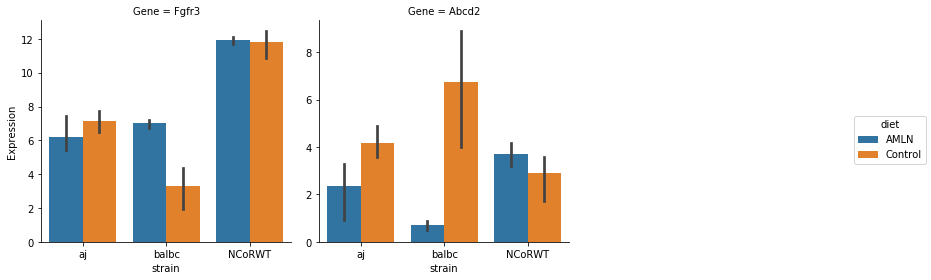

In [78]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + balb_spec_genes))

### Kuppfer cell Expression of Balbc Whole liver specific genes

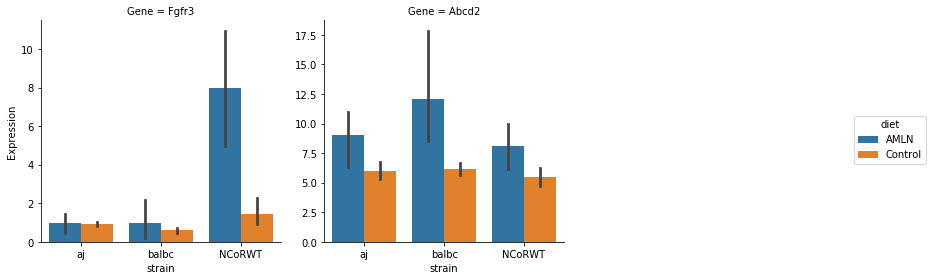

In [80]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + balb_spec_genes))

### AJ differentially regulated genes

In [81]:
aj_amln = pd.read_csv(outdir + "/aj_amln_wholeliver_deseq_results.txt")
aj_balb = pd.read_csv(outdir + "/balbc_aj_amln_interaction_wholeliver_deseq_results.txt")
aj_ncor = pd.read_csv(outdir + "/aj_ncorwt_amln_interaction_wholeliver_deseq_results.txt")

In [82]:
# combine into one DF
aj = aj_amln.merge(aj_balb.merge(aj_ncor, how='outer', on='Unnamed: 0',
                                    suffixes=('_aj_balb', '_aj_ncor')),
                      how='outer', on='Unnamed: 0')

In [83]:
aj_balb_spec = ((np.abs(aj.log2FoldChange) >= 1) & (aj.padj <=0.05) & (aj.padj_aj_balb <= 0.05))
aj_balb_spec.value_counts()

False    24534
True         3
dtype: int64

In [84]:
aj_ncor_spec = ((np.abs(aj.log2FoldChange) >= 1) & (aj.padj <=0.05) & (aj.padj_aj_ncor <= 0.05))
aj_ncor_spec.value_counts()

False    24525
True        12
dtype: int64

In [85]:
((aj_balb_spec) & (aj_ncor_spec)).value_counts()

False    24536
True         1
dtype: int64

In [86]:
# aj specific refseq ids
aj_spec_refseq = aj.loc[((aj_balb_spec) & (aj_ncor_spec)), 'Unnamed: 0']

# Get aj spec gene names
aj_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(aj_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

In [87]:
aj_spec_genes

9272    Cyp2c29
Name: Annotation/Divergence, dtype: object

#### Plot Whole Liver Specific Genes

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


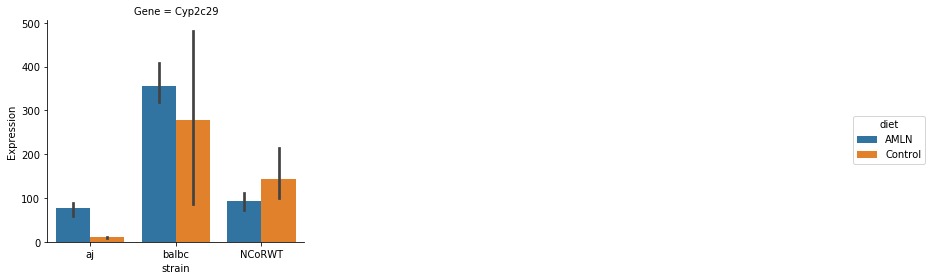

In [88]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + aj_spec_genes))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


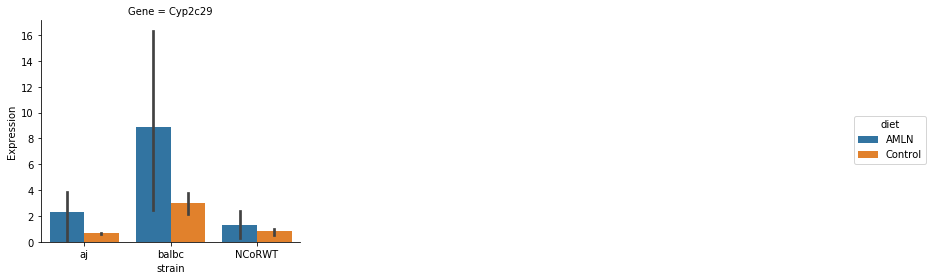

In [89]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + aj_spec_genes))

#### NCoRWT (C57 BL6) specific genes

In [90]:
ncorwt_amln = pd.read_csv(outdir + "/ncorwt_amln_wholeliver_deseq_results.txt")
ncorwt_aj = pd.read_csv(outdir + "/aj_ncorwt_amln_interaction_wholeliver_deseq_results.txt")
ncorwt_balb = pd.read_csv(outdir + "/balbc_ncorwt_amln_interaction_wholeliver_deseq_results.txt")

In [91]:
# combine into one DF
ncorwt = ncorwt_amln.merge(ncorwt_balb.merge(ncorwt_aj, how='outer', on='Unnamed: 0',
                                             suffixes=('_ncorwt_balb', '_ncorwt_aj')), 
                           how='outer', on='Unnamed: 0')

In [92]:
ncorwt_balb_spec = ((np.abs(ncorwt.log2FoldChange) >= 1) & (ncorwt.padj <=0.05) & (ncorwt.padj_ncorwt_balb <= 0.05))
ncorwt_balb_spec.value_counts()

False    24449
True        88
dtype: int64

In [93]:
ncorwt_aj_spec = ((np.abs(ncorwt.log2FoldChange) >= 1) & (ncorwt.padj <=0.05) & (ncorwt.padj_ncorwt_aj <= 0.05))
ncorwt_aj_spec.value_counts()

False    24476
True        61
dtype: int64

In [94]:
(ncorwt_aj_spec & ncorwt_balb_spec).value_counts()

False    24499
True        38
dtype: int64

In [95]:
# ncorwt specific refseq ids
ncorwt_spec_refseq = ncorwt.loc[((ncorwt_balb_spec) & (ncorwt_aj_spec)), 'Unnamed: 0']

# Get ncorwt spec gene names
ncorwt_spec_genes = rpkm_genes_raw.loc[rpkm_genes_raw.iloc[:, 0].str.contains('|'.join(ncorwt_spec_refseq)),
                                    'Annotation/Divergence'].str.split('\|').str[0]

#### Kupffer cell expression

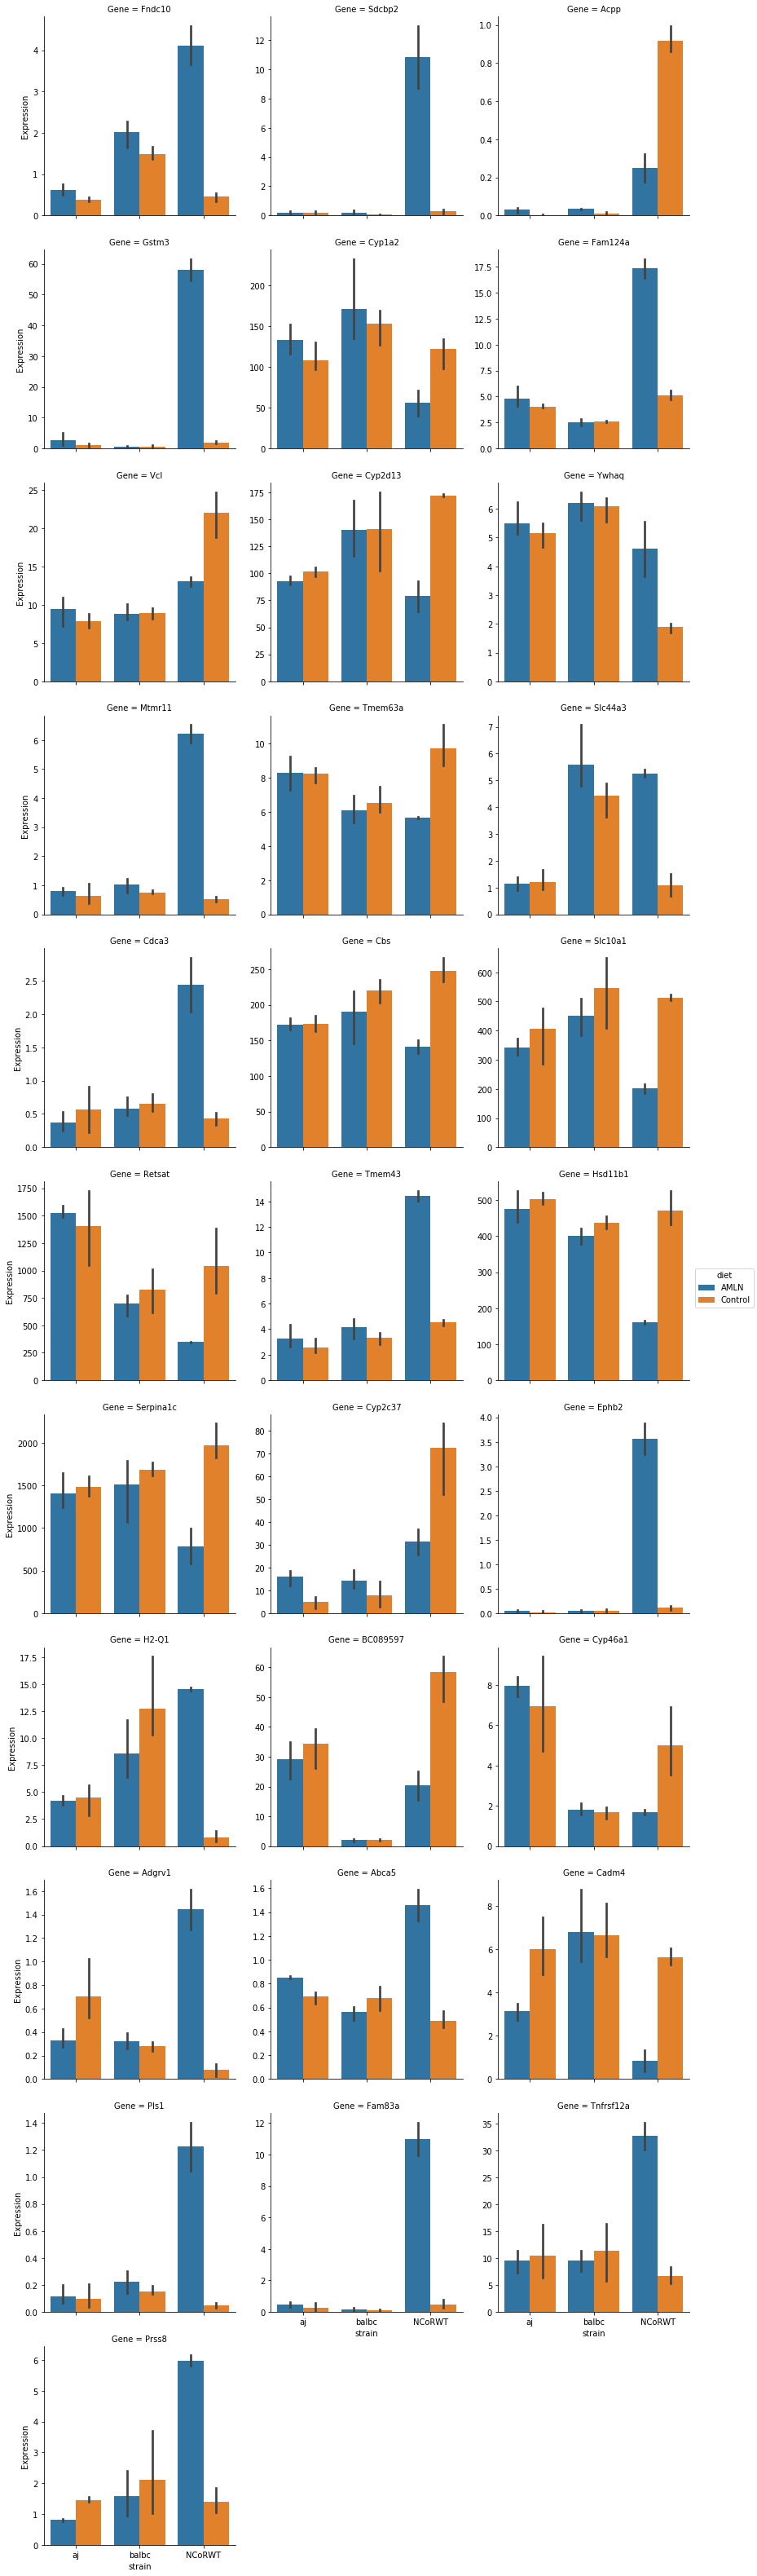

In [96]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l, '|'.join('^' + ncorwt_spec_genes + '\|'))

#### liver expression


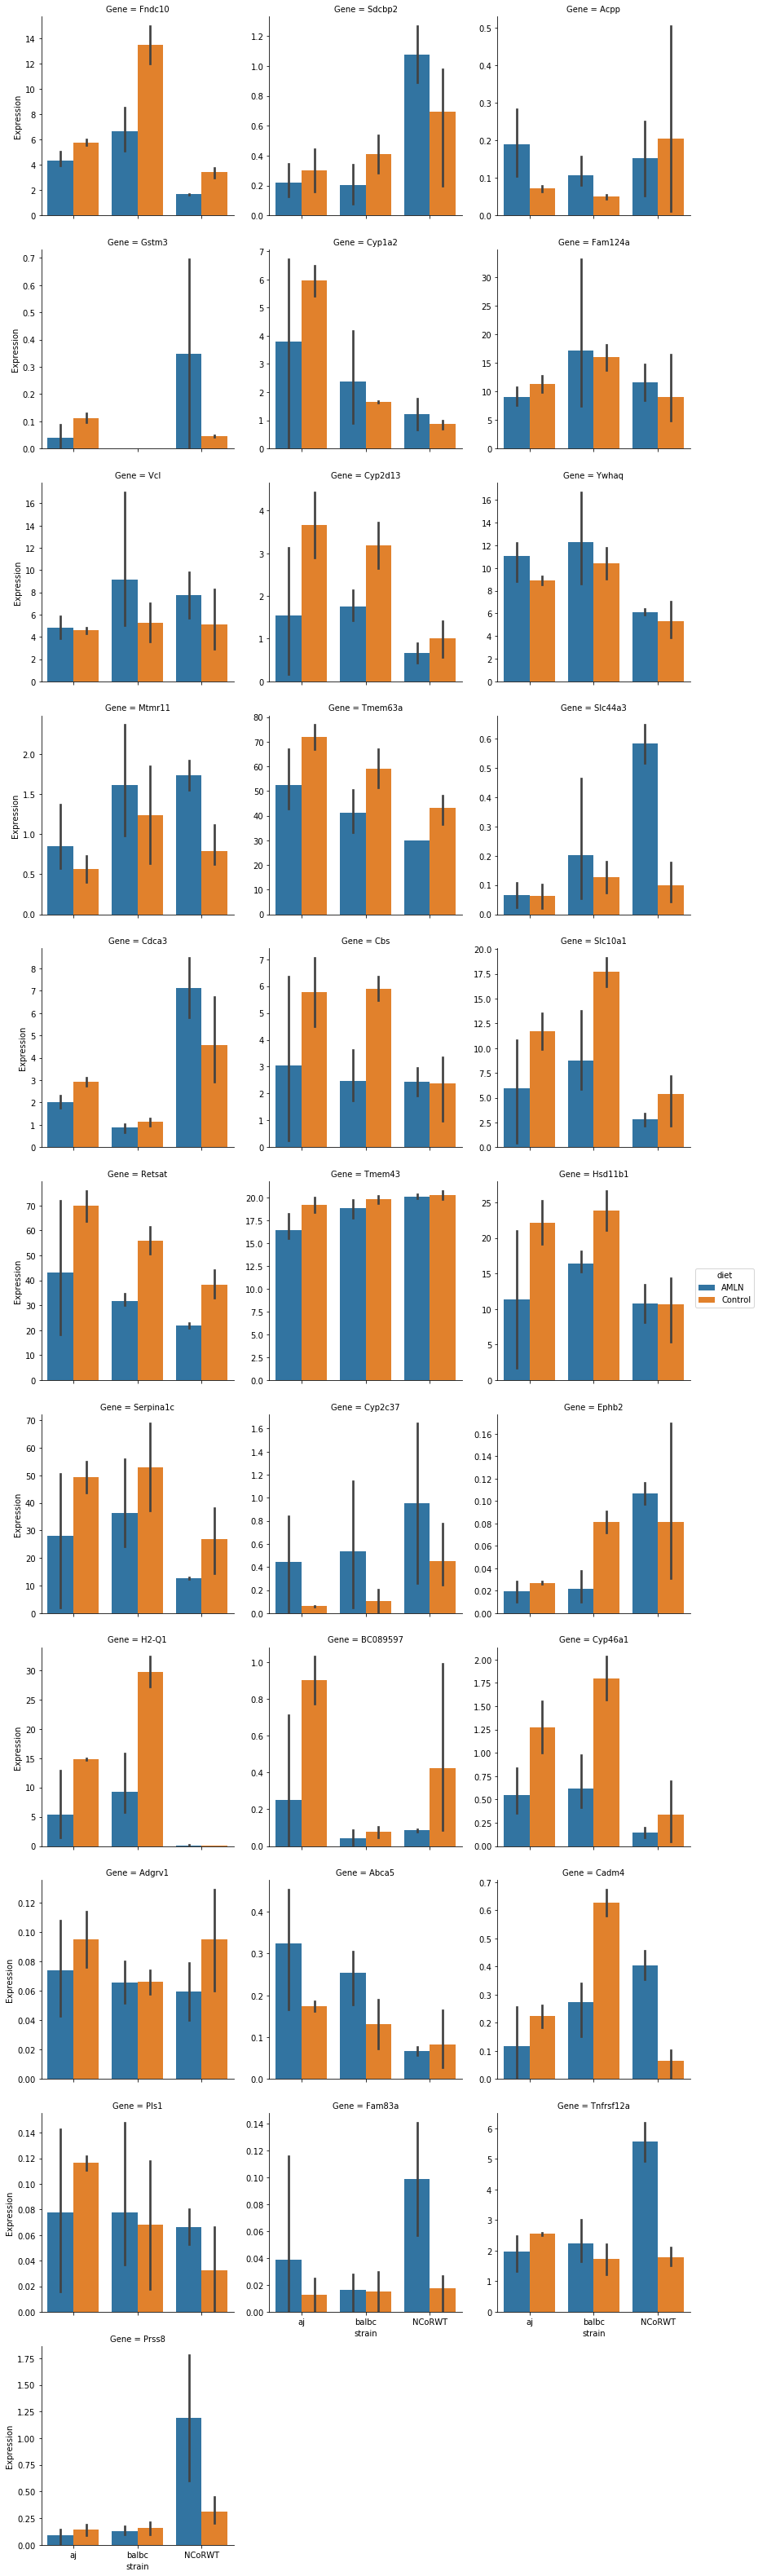

In [97]:
hbUtils.plot_gene_exp(rpkm_genes_raw_k, '|'.join('^' + ncorwt_spec_genes + '\|'))

GO enrichment of refseq IDs using PANTHER at www.geneontology.org shows only one enriched pathway amongst the differentially regulated genes in NCoRWT. They are all involved in the steroid catabolic process and are all downregulated in whole liver RNA samples.
GO:0006706: steroid catabolic process.
* NM_009993 Cytochrome P450 1A2 Cyp1A2 (induced by NRF2 in the oxidative stress response)
* NM_001044751 Corticosteroid 11-beta-dehydrogenase isozyme 1 Hsd11b1
* NM_010010 Cholesterol 24-hydroxylase Cyp46a1 produces 24SOH-Chol, an important substrate for LXR at least in the brain

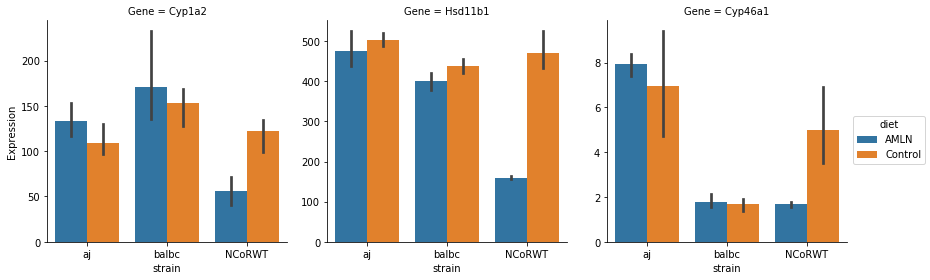

In [103]:
hbUtils.plot_gene_exp(rpkm_genes_raw_l,
        '|'.join('^' + pd.Series(['Cyp1a2', 'Hsd11b1', 'Cyp46a1'])))